In [1]:
# --- 1. INSTALLATION (Uncomment and run if you have ModuleNotFoundError) ---
# !pip install numpy pandas matplotlib statsmodels scikit-learn

# --- 2. IMPORTS ---
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import tkinter as tk
from tkinter import filedialog

# Suppress the main tkinter window that opens when importing filedialog
tk.Tk().withdraw() 

print("✅ Libraries installed (if needed) and imported.")

✅ Libraries installed (if needed) and imported.


In [2]:
# --- 3. READ DATA FROM USER SELECTED FILE ---

def select_csv_file():
    """Opens a file dialog for the user to select a CSV file."""
    
    file_path = filedialog.askopenfilename(
        title="Select your MMM CSV Data File",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*"))
    )
    return file_path

# Execute file selection and loading
csv_path = select_csv_file()

if not csv_path:
    raise FileNotFoundError("ERROR: No file selected. Please run the cell again and choose a CSV file.")

try:
    # Assumes the date column is named 'week' as per your data
    df = pd.read_csv(csv_path, parse_dates=['week']) 
    print(f"✅ Data loaded successfully from: {csv_path}")
    print(f"Data shape: {df.shape}")
    
except Exception as e:
    raise Exception(f"ERROR: Failed to read CSV or parse dates. Check file format. Error: {e}")

# Store the clean DataFrame globally for the next cells
df_raw = df.copy()


✅ Data loaded successfully from: C:/Alby/PythonTraining/Skill Development/Python/MMM/Data/Data final/data_sample_104weeks.csv
Data shape: (104, 7)


In [3]:
# --- 4. DATA VALIDATION, ADSTOCK, AND TRANSFORMATION FUNCTIONS ---

def validate_data(df, required_cols, date_col='week', target_col='sales'):
    """Validates the DataFrame for required columns and data types."""
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in data: {missing_cols}")
        
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        raise TypeError(f"Target column '{target_col}' must be numeric.")
        
    non_numeric = [col for col in required_cols if col != date_col and col != target_col and not pd.api.types.is_numeric_dtype(df[col])]
    if non_numeric:
        df[non_numeric] = df[non_numeric].apply(pd.to_numeric, errors='coerce')
        
    return df

def adstock_transform(series, decay=0.5):
    """Applies a geometric adstock transformation."""
    out = np.zeros_like(series, dtype=float)
    for i in range(len(series)):
        if i == 0:
            out[i] = series[i]
        else:
            out[i] = series[i] + decay * out[i-1]
    return out

def apply_transforms(df, adstock_params):
    """Applies adstock and creates seasonal features."""
    df_model = df.copy()
    adstock_cols = []
    
    # Adstock Transformation
    for col, decay in adstock_params.items():
        adstock_name = f'{col}_adstock'
        if col not in df_model.columns:
             raise ValueError(f"Media spend column '{col}' not found for adstocking.")
             
        df_model[adstock_name] = adstock_transform(df_model[col].values, decay=decay)
        adstock_cols.append(adstock_name)
        
    # Seasonal Features (sin/cos on a 52-week cycle)
    n_weeks = len(df_model)
    df_model['sin52'] = np.sin(2 * np.pi * np.arange(n_weeks) / 52)
    df_model['cos52'] = np.cos(2 * np.pi * np.arange(n_weeks) / 52)
    
    return df_model, adstock_cols


# --- EXECUTE VALIDATION AND TRANSFORMATION ---
# Define ALL required columns based on your provided data structure
REQUIRED_COLS = [
    'week', 'tv_spend', 'digital_spend', 'print_spend', 
    'price', 'promotions', 'sales'
]

# Define adstock decay parameters (can be changed)
ADSTOCK_DECAY = {
    'tv_spend': 0.6, 
    'digital_spend': 0.4, 
    'print_spend': 0.5
}

# 1. Validation
df_clean = validate_data(df_raw, REQUIRED_COLS)
print("✅ Data Validated.")

# 2. Transformation
df_model, ADSTOCK_COLS = apply_transforms(df_clean, ADSTOCK_DECAY)
print("✅ Adstock and Seasonal Transformations Applied.")

✅ Data Validated.
✅ Adstock and Seasonal Transformations Applied.


In [4]:
# --- 5. OLS MMM MODEL FITTING ---

def fit_mmm(df_model, adstock_cols):
    """Fits the OLS model using adstocked media, price, promotions, and seasonality."""
    
    # Define Model Features (X) and Target (y)
    Xcols = adstock_cols + ['price', 'promotions', 'sin52', 'cos52']
    
    X = df_model[Xcols]
    X = sm.add_constant(X) # Add the intercept term (Base Sales)
    y = df_model['sales']
    
    # Fit the OLS Model
    try:
        model = sm.OLS(y, X).fit(cov_type='HC3') # HC3 robust errors are standard for MMM
        return model, Xcols
    except Exception as e:
        raise Exception(f"ERROR during model fitting: {e}")


# --- EXECUTE MODEL FITTING ---
model, XCOLS = fit_mmm(df_model, ADSTOCK_COLS)

# --- MODEL EVALUATION ---
preds = model.predict(sm.add_constant(df_model[XCOLS]))
mse = mean_squared_error(df_model['sales'], preds)
r2 = r2_score(df_model['sales'], preds)

print("✅ OLS Model Fitted.")
print("\n--- Model Summary (Coefficients, P-Values, R2) ---")
print(model.summary().tables[1].as_text())
print(f'\nMetrics: MSE={mse:.2f}, R2={r2:.3f}')

✅ OLS Model Fitted.

--- Model Summary (Coefficients, P-Values, R2) ---
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -353.4159    165.153     -2.140      0.032    -677.110     -29.722
tv_spend_adstock          0.0331      0.005      6.486      0.000       0.023       0.043
digital_spend_adstock     0.0379      0.009      4.167      0.000       0.020       0.056
print_spend_adstock       0.0130      0.009      1.399      0.162      -0.005       0.031
price                   -26.8477      5.444     -4.932      0.000     -37.518     -16.177
promotions              100.6308     20.597      4.886      0.000      60.262     141.000
sin52                    11.1908     14.996      0.746      0.456     -18.200      40.582
cos52                    15.8691     17.274      0.919      0.358     -17.988      49.726

Metrics: MSE=10031.89, R2=0

In [6]:
# --- 6. CONTRIBUTION AND ROI CALCULATION ---

# MODIFIED FUNCTION: Added 'X_cols' parameter to accept the feature list
def compute_contributions_and_roi(model, df_model, adstock_params, X_cols):
    """Calculates sales contribution for each feature and ROI for media."""
    
    # model.params['const'] is available on the OLSResults object
    base_sales = model.params['const'] * len(df_model)
    contributions = {'Base': base_sales}
    
    # Calculate contribution for each feature
    # Use the X_cols list (the features passed to OLS) + 'const'
    feature_names_with_const = ['const'] + X_cols 
    
    for feature in feature_names_with_const:
        if feature != 'const':
            # model.params[feature] is available on the OLSResults object
            contributions[feature] = (model.params[feature] * df_model[feature]).sum()
            
    # Re-group Adstock contributions back to original media names
    media_contributions = {}
    other_contributions = {}
    
    for feature, contribution in contributions.items():
        is_media = False
        for media_name in adstock_params.keys():
            if media_name in feature:
                media_contributions[media_name] = media_contributions.get(media_name, 0) + contribution
                is_media = True
                break
        if not is_media and feature != 'Base': # Changed to check for 'Base' instead of 'const'
            other_contributions[feature] = contribution
            
    # Include Base in the other contribution sum
    total_other_contribution = sum(other_contributions.values()) + contributions.get('Base', 0)
    
    # Calculate ROI (Sales Contribution / Spend)
    roi_data = {}
    for media, contrib in media_contributions.items():
        total_spend = df_model[media].sum()
        if total_spend > 0:
            roi = contrib / total_spend
            roi_data[media] = {'Total Spend': total_spend, 'Sales Contribution': contrib, 'ROI': roi}
        else:
            roi_data[media] = {'Total Spend': 0, 'Sales Contribution': 0, 'ROI': 0}
            
    return media_contributions, total_other_contribution, roi_data

# --- EXECUTE CONTRIBUTION & ROI CALCULATION ---
# MODIFIED EXECUTION: Pass the XCOLS list from Cell 4
media_contribs, other_contrib, roi_data = compute_contributions_and_roi(model, df_model, ADSTOCK_DECAY, XCOLS)

print("✅ Contribution and ROI Calculated.")

# Print Summary
print("\n--- Contribution & ROI Summary ---")
contrib_df = pd.DataFrame(media_contribs.items(), columns=['Channel', 'Sales Contribution (Units)'])
print("\n[Sales Contributions]")
print(contrib_df)
print(f"Base/Other Contribution (Includes Price/Promo/Seasonality): {other_contrib:.0f} units")

roi_df = pd.DataFrame.from_dict(roi_data, orient='index')
print("\n[Return on Investment (ROI)]")
print(roi_df.round(2))

✅ Contribution and ROI Calculated.

--- Contribution & ROI Summary ---

[Sales Contributions]
         Channel  Sales Contribution (Units)
0       tv_spend                50762.142137
1  digital_spend                30888.100177
2    print_spend                 7899.742954
Base/Other Contribution (Includes Price/Promo/Seasonality): -62549 units

[Return on Investment (ROI)]
               Total Spend  Sales Contribution   ROI
tv_spend            624563            50762.14  0.08
digital_spend       491829            30888.10  0.06
print_spend         306683             7899.74  0.03


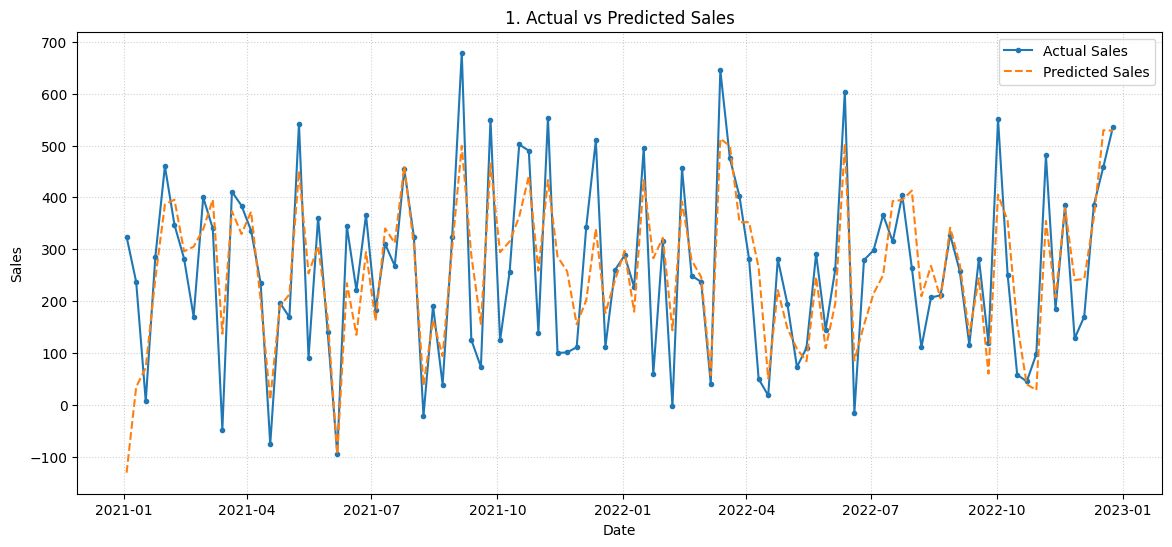

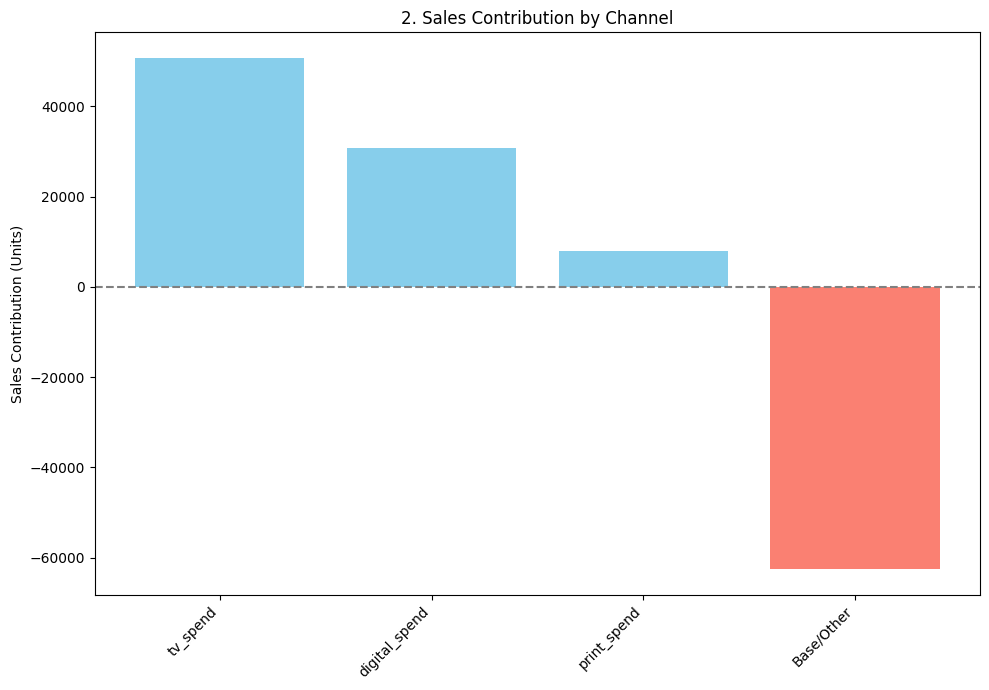

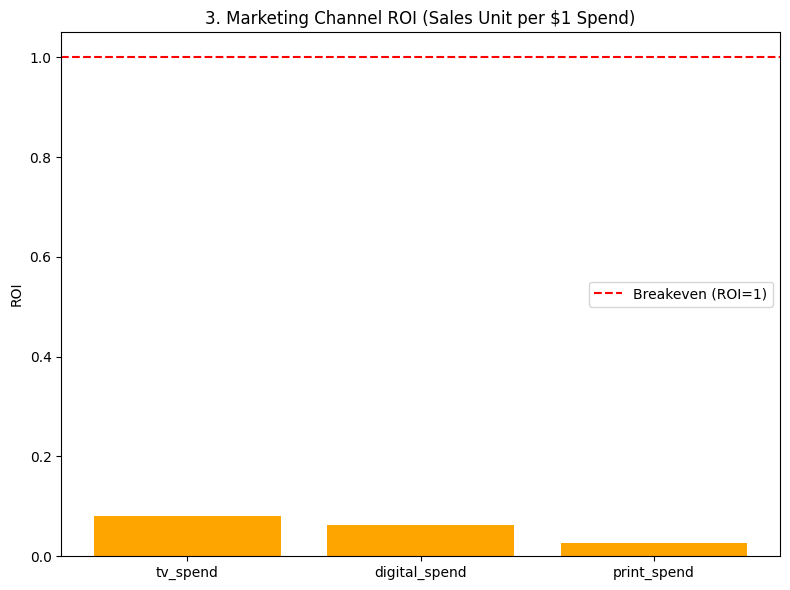

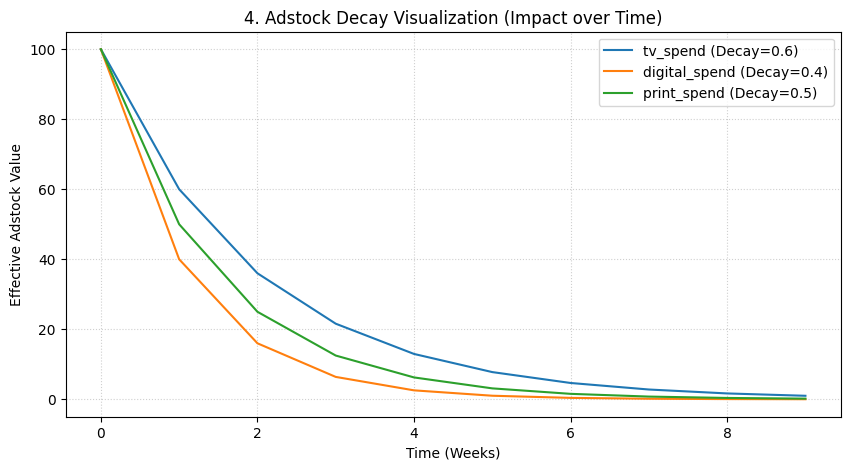

✅ Plots generated and saved to ./output directory and displayed above.


In [8]:
# --- 7. PLOTTING FUNCTIONS ---

# MODIFIED FUNCTION SIGNATURE: Added 'X_cols' parameter
def plot_results(df, model, media_contributions, total_other_contribution, roi_data, adstock_params, X_cols, outdir='output'):
    """Generates all required plots."""
    
    os.makedirs(outdir, exist_ok=True)
    
    # 1. Actual vs Predicted Sales
    plt.figure(figsize=(14, 6))
    plt.plot(df['week'], df['sales'], label='Actual Sales', marker='.', linestyle='-')
    
    # FIX: Use the passed X_cols list instead of model.exog_names
    preds = model.predict(sm.add_constant(df[X_cols]))
    
    plt.plot(df['week'], preds, label='Predicted Sales', linestyle='--')
    plt.title('1. Actual vs Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.savefig(os.path.join(outdir, '1_actual_vs_predicted.png'))
    plt.show()
    plt.close()
    
    # 2. Sales Contribution Waterfall/Bar Chart (No change here, as it uses pre-computed contributions)
    contrib_data = {'Base/Other': total_other_contribution}
    contrib_data.update(media_contributions)
    sorted_contrib = {k: v for k, v in sorted(contrib_data.items(), key=lambda item: item[1], reverse=True)}
    labels = list(sorted_contrib.keys())
    values = list(sorted_contrib.values())
    
    plt.figure(figsize=(10, 7))
    plt.bar(labels, values, color=['skyblue' if v > 0 else 'salmon' for v in values])
    plt.axhline(0, color='gray', linestyle='--')
    plt.title('2. Sales Contribution by Channel')
    plt.ylabel('Sales Contribution (Units)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, '2_contributions.png'))
    plt.show()
    plt.close()
    
    # 3. ROI (Return on Investment) Bar Chart
    roi_labels = list(roi_data.keys())
    roi_values = [data['ROI'] for data in roi_data.values()]
    
    plt.figure(figsize=(8, 6))
    plt.bar(roi_labels, roi_values, color=['green' if v > 1.0 else 'orange' if v > 0 else 'red' for v in roi_values])
    plt.axhline(1.0, color='red', linestyle='--', label='Breakeven (ROI=1)')
    plt.title('3. Marketing Channel ROI (Sales Unit per $1 Spend)')
    plt.ylabel('ROI')
    plt.xticks(rotation=0)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, '3_roi.png'))
    plt.show()
    plt.close()
    
    # 4. Adstock Curves (Illustrative)
    plt.figure(figsize=(10, 5))
    initial_pulse = np.zeros(10)
    initial_pulse[0] = 100 
    
    for col, decay in adstock_params.items():
        adstock_series = adstock_transform(initial_pulse, decay=decay)
        plt.plot(adstock_series, label=f'{col} (Decay={decay})')
        
    plt.title('4. Adstock Decay Visualization (Impact over Time)')
    plt.xlabel('Time (Weeks)')
    plt.ylabel('Effective Adstock Value')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.savefig(os.path.join(outdir, '4_adstock_curves.png'))
    plt.show()
    plt.close()

# --- EXECUTE PLOTTING ---
# FIX: Pass the XCOLS variable from Cell 4 to the plotting function
plot_results(df_model, model, media_contribs, other_contrib, roi_data, ADSTOCK_DECAY, XCOLS)
print("✅ Plots generated and saved to ./output directory and displayed above.")